## Building Linear model

In [4]:
%pip install pandas
%pip install scikit-learn
%pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import scipy.stats as spy
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

2023-08-29 23:51:13.248401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarnin

In [3]:
# Load your data into a pandas DataFrame
df = pd.read_csv("data/powerconsumption.csv");
df.drop(["DiffuseFlows"], axis=1, inplace=True)
df.Datetime = pd.to_datetime(df.Datetime);
reference_datetime = pd.to_datetime("01/01/2017 00:00", format='%d/%m/%Y %H:%M')
df.Datetime = ((df['Datetime'] - reference_datetime).dt.total_seconds() // 60) % 60
df

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,0.0,6.559,73.8,0.083,0.051,34055.69620,16128.87538,20240.96386
1,10.0,6.414,74.5,0.083,0.070,29814.68354,19375.07599,20131.08434
2,20.0,6.313,74.5,0.080,0.062,29128.10127,19006.68693,19668.43373
3,30.0,6.121,75.0,0.083,0.091,28228.86076,18361.09422,18899.27711
4,40.0,5.921,75.7,0.081,0.048,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
52411,10.0,7.010,72.4,0.080,0.040,31160.45627,26857.31820,14780.31212
52412,20.0,6.947,72.6,0.082,0.051,30430.41825,26124.57809,14428.81152
52413,30.0,6.900,72.8,0.086,0.084,29590.87452,25277.69254,13806.48259
52414,40.0,6.758,73.0,0.080,0.066,28958.17490,24692.23688,13512.60504


In [4]:
# Define the number of time steps (days)
time_steps = 6*24*7

In [5]:
# Split the data into features (X) and target (y)
features = ["Datetime", "Temperature", "Humidity", "WindSpeed", "GeneralDiffuseFlows"]
target = ['PowerConsumption_Zone1']

X = df[features]
y = df[target]

In [6]:
# Normalize the features and target using Min-Max scaling
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [7]:
# Create sequences for LSTM input
X_sequences = []
y_sequences = []

In [8]:
for i in range(len(X_scaled) - time_steps + 1):
    X_sequences.append(X_scaled[i:i+time_steps, :])
    # Use the avg of the last consumption as target of the last 7 days
    y_sequences.append(np.mean(y_scaled[i:i+time_steps, 0]))
    # y_sequences.append(y_scaled[i+time_steps-1, 0])  # Use the last day's power consumption as target

# X_sequences = np.array(X_scaled.reshape(len(X_scaled), 1, 5))
# y_sequences = np.array(y_scaled)

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [9]:
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

In [10]:
# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(16, activation='tanh', input_shape=(time_steps, len(features))),
    tf.keras.layers.Dense(1, activation='linear')
])

2023-08-29 23:51:23.816328: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-08-29 23:51:24.066728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-29 23:51:24.068506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-29 23:51:24.0

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Train the model
model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

2023-08-29 23:51:29.302981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-29 23:51:29.304879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-29 23:51:29.306234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1286/1286 [==============================] - ETA: 0s - loss: 0.0110

2023-08-29 23:57:31.359085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-29 23:57:31.360937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-29 23:57:31.362209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1286/1286 [==============================] - 381s 295ms/step - loss: 0.0110 - val_loss: 0.0018


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1408      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


  1/322 [..............................] - ETA: 2:12

2023-08-29 23:57:50.468711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-29 23:57:50.470410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-29 23:57:50.471689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

322/322 [==============================] - 21s 65ms/step


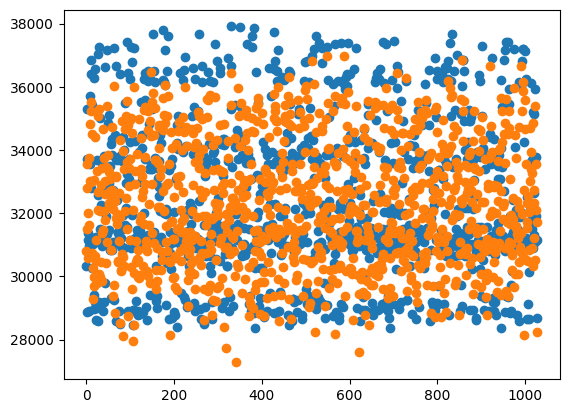

Mean Squared Error: 2644040.76


In [14]:
# Make predictions using the test dataset
y_pred_scaled = model.predict(X_test)

# Inverse transform the scaled predictions to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Inverse transform the scaled actual values (if needed)
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))


y_actual_plt = y_actual[:len(y_actual)//10]
y_pred_plt = y_pred[:len(y_actual)//10]
fig,ax = plt.subplots()
ax.scatter(range(len(y_actual_plt)), y_actual_plt)
ax.scatter(range(len(y_pred_plt)), y_pred_plt)
plt.show()

# Calculate performance metrics (e.g., Mean Squared Error)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_actual, y_pred)
print(f"Mean Squared Error: {mse:.2f}")


In [19]:
# Upload to minio server
from minio import Minio
import 
tf.keras.models.save_model(model,"lstm")
minio_client = Minio(
    "172.20.126.215:9000",
    access_key="minio",
    secret_key="minio123",
    secure=False
)

def upload_local_directory_to_minio(local_path, bucket_name, minio_path):
        assert os.path.isdir(local_path)
        for local_file in glob.glob(local_path + '/**'):
            local_file = local_file.replace(os.sep, "/") # Replace \ with / on Windows
            if not os.path.isfile(local_file):
                upload_local_directory_to_minio(
                    local_file, bucket_name, minio_path + "/" + os.path.basename(local_file))
            else:
                remote_path = os.path.join(
                    minio_path, local_file[1 + len(local_path):])
                remote_path = remote_path.replace(
                    os.sep, "/")  # Replace \ with / on Windows
                minio_client.fput_object(bucket_name, remote_path, local_file)

upload_local_directory_to_minio("lstm", "mlpipeline", "lstm")

2023-08-30 00:13:30.184667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-30 00:13:30.186341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-30 00:13:30.187579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


NameError: name 'os' is not defined